# Parte 1 - Descarga y exploración del corpus

### Importaciones

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from nltk import RegexpTokenizer
from collections import Counter
from stop_words import get_stop_words
from nltk import ngrams

from wordcloud import WordCloud
from num2words import num2words
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models.word2vec import LineSentence
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE


### Cargamos los datos

In [2]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Amazon_Instant_Video.csv

data_reviews = pd.read_json('reviews_Amazon_Instant_Video_5.json.gz', 
                            lines=True, compression='gzip')

data_ratings = pd.read_csv('ratings_Amazon_Instant_Video.csv',header = None)

In [3]:
data_reviews.head(1)

reviewerID        asin reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ     AdrianaM  [0, 0]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   

                      summary  unixReviewTime  reviewTime  
0  A little bit boring for me      1399075200  05 3, 2014

In [4]:
data_ratings.head(1)

0           1    2           3
0  A1EE2E3N7PW666  B000GFDAUG  5.0  1202256000

Nos quedamos con las columnas importantes para nuestro análisis de sentimiento

In [5]:
data_reviews = data_reviews[['reviewerID', 'summary', 'reviewText', 'overall']]
data_ratings = data_ratings[[0,2]]
data_ratings.columns = ['reviewerID','ratings']

In [6]:
lista_de_ids = list(data_reviews['reviewerID'])
for id in list(data_reviews['reviewerID']):
    print(data_ratings[data_ratings['reviewerID'] == id])
    print(data_reviews[data_reviews['reviewerID'] == id][['reviewerID','overall']])
    break

            reviewerID  ratings
175     A11N155CW1UV02      2.0
222612  A11N155CW1UV02      4.0
248640  A11N155CW1UV02      3.0
372657  A11N155CW1UV02      3.0
461472  A11N155CW1UV02      2.0
519172  A11N155CW1UV02      2.0
520921  A11N155CW1UV02      3.0
           reviewerID  overall
0      A11N155CW1UV02        2
13362  A11N155CW1UV02        4
15080  A11N155CW1UV02        3
23207  A11N155CW1UV02        3
28465  A11N155CW1UV02        2
33102  A11N155CW1UV02        3


Vemos que overall coincide con ratings, por lo que nos quedaremos solo con data_reviews

### Tokenización

In [7]:
# Esta función tokeniza, elimina signos de puntuación,lematiza y elimina StopWords
def list_to_words(text):
    words = []
    sw_list = get_stop_words('en')
    
    for sentence in text:
        
        for word in RegexpTokenizer(r"\w+").tokenize(sentence):            
            #w = RegexpTokenizer(r"\w+\'\w+|\w+").tokenize(w)
            
            if word.lower() not in sw_list:
                clean_word = WordNetLemmatizer().lemmatize(word).lower().strip()               
                if clean_word.isdigit():
                    clean_word = num2words(clean_word, lang='en')                    
                if (len(clean_word) > 3):
                    words.append(clean_word)
                
    return words

In [8]:
words_in_reviews = list_to_words(data_reviews['reviewText'])
print(len(words_in_reviews))
print(words_in_reviews[:100])

1605748
['expectation', 'love', 'english', 'particular', 'investigative', 'detective', 'stuff', 'really', 'boring', 'didn', 'appeal', 'highly', 'recommend', 'series', 'must', 'anyone', 'yearning', 'watch', 'grown', 'television', 'complex', 'character', 'plot', 'keep', 'totally', 'involved', 'thank', 'amazin', 'prime', 'real', 'snoozer', 'believe', 'anything', 'read', 'hear', 'awful', 'idea', 'title', 'mean', 'neither', 'will', 'mysteries', 'interesting', 'tension', 'robson', 'tall', 'blond', 'good', 'always', 'believable', 'often', 'seemed', 'uncomfortable', 'show', 'always', 'excellent', 'british', 'crime', 'mystery', 'showsgoes', 'best', 'ever', 'made', 'story', 'well', 'done', 'acting', 'notch', 'interesting', 'twist', 'realistic', 'brutal', 'storyline', 'show', 'pull', 'punch', 'enters', 'twisted', 'mind', 'criminal', 'profiler', 'psychiatrist', 'help', 'northern', 'english', 'city', 'police', 'force', 'show', 'look', 'like', 'shot', 'manchester', 'called', 'another', 'name', 'show

In [9]:
words_in_summary = list_to_words(data_reviews['summary'])
print(len(words_in_summary))
print(words_in_summary[:100])

97083
['little', 'boring', 'excellent', 'grown', 'boring', 'robson', 'green', 'mesmerizing', 'robson', 'green', 'great', 'writing', 'purchased', 'series', 'streaming', 'loved', 'take', 'time', 'reasonable', 'kill', 'minute', 'kansas001', 'entertaining', 'comedy', 'worth', 'watching', 'comedy', 'club', 'quality', 'without', 'leaving', 'home', 'sure', 'loved', 'routine', 'last', 'comic', 'standing', 'watched', 'wanda', 'sykes', 'funny', 'kansa', 'something', 'want', 'watch', 'comedian', 'clip', 'excellent', 'funny', 'matter', 'preference', 'pretty', 'good', 'great', 'okay', 'series', 'stopped', 'watching', 'episode', 'never', 'dull', 'moment', 'best', 'underrated', 'series', 'ever', 'always', 'sunny', 'four', 'episode', 'dumb', 'sleazy', 'funny', 'just', 'stupid', 'great', 'always', 'funny', 'philadelphia', 'always', 'sunny', 'philadelphia', 'season', 'often', 'funny', 'philly', 'occasionally', 'hilarious', 'best', 'wrong', 'subtraction', 'addition', 'hilarious', 'version', 'coupling', '

### Cardinalidad del vocabulario

In [10]:
reviews_word_freqs = Counter(words_in_reviews)
summary_word_freqs = Counter(words_in_summary)

print("Reviews\n",reviews_word_freqs.most_common(25),"\nSummary\n",summary_word_freqs.most_common(25))

Reviews
 [('show', 30500), ('season', 19948), ('like', 15092), ('character', 13730), ('series', 12903), ('episode', 12867), ('good', 12693), ('just', 11465), ('great', 10605), ('thirty-four', 10184), ('story', 9902), ('love', 9633), ('movie', 9273), ('watch', 9125), ('really', 9097), ('time', 9006), ('will', 8653), ('well', 8287), ('film', 7869), ('make', 7018), ('much', 6468), ('first', 6451), ('watching', 5927), ('people', 5561), ('even', 5417)] 
Summary
 [('show', 4784), ('great', 3833), ('good', 2792), ('season', 2669), ('love', 2242), ('series', 1895), ('best', 1150), ('like', 807), ('better', 783), ('movie', 704), ('interesting', 687), ('funny', 630), ('excellent', 601), ('watch', 594), ('just', 561), ('story', 533), ('five', 499), ('awesome', 495), ('really', 482), ('entertaining', 477), ('episode', 466), ('three', 461), ('time', 449), ('well', 420), ('drama', 417)]


Parece que en el summary tienen más relevancia los calificativos

### Distribución de reviews por número de estrellas

In [11]:
data_reviews['overall'].value_counts(1)

5    0.562678
4    0.227496
3    0.112778
2    0.050773
1    0.046275
Name: overall, dtype: float64

Vemos que casi el 80% de las reviews tienen 4 o 5 estrellas

Solo el 5% de las reviews tienen menos de 3 estrellas

### Nº de reviews positivas y negativas

In [12]:
len(data_reviews[data_reviews['overall']>2])

33523

In [13]:
len(data_reviews[data_reviews['overall']<3])

3603

### N-grams más frecuentes y Nube de Palabras

In [14]:
#Función que devuelve lista de palabras y los bigramas,trigramas y palabras mas frecuentes
def n_grams(columna, stars = 0):
    if (stars == 0):
        words_in_reviews = list_to_words(data_reviews[columna])
    else:
        words_in_reviews = list_to_words(
            data_reviews[data_reviews['overall'] == stars][columna]) 
    
    bigrams = list(ngrams(words_in_reviews, 2))   
    trigrams = list(ngrams(words_in_reviews, 3))
    
    return [words_in_reviews,
            Counter(bigrams).most_common(25), 
            Counter(trigrams).most_common(25),
            Counter(words_in_reviews).most_common(25)]

# Fucion para representar histogramas
def crear_histo (lista):
    words3 = [str(w[0]) for w in lista]
    freqs3 = [w[1] for w in lista]
    freqs3, words3 = zip(*sorted(zip(freqs3, words3)))
    plt.barh(words3, freqs3)
    plt.show()   
    
# Fucion para representar Nubes de palabras   
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()   

In [15]:
def general():
    text = ['Palabras', 'Bigramas', 'Trigramas']
    
    n_gram_reviews = n_grams('reviewText')  
    n_gram_summary = n_grams('summary')  
    
    print(f'{text[0]} mas frecuentes para todas las reviews')
    crear_histo(n_gram_reviews[3])
    print(f'{text[0]} mas frecuentes para todas los summary')
    crear_histo(n_gram_summary[3])

    print (f'N-grams de todas las reviews\n')
    for j in range(1,3):
        print(f'{text[j]} más frecuentes')
        crear_histo(n_gram_reviews[j])
        
    print (f'N-grams de todas los summary\n')
    for j in range(1,3):
        print(f'{text[j]} más frecuentes')
        crear_histo(n_gram_summary[j])

    print ('Nube de palabras para reviews')
    plot_word_cloud(n_gram_reviews[0])
    print ('Nube de palabras para summary')
    plot_word_cloud(n_gram_summary[0])
    
    return n_gram_reviews[0], n_gram_summary[0]

Palabras mas frecuentes para todas las reviews


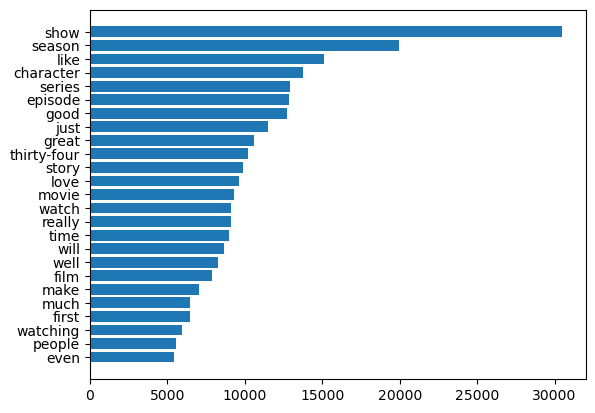

Palabras mas frecuentes para todas los summary


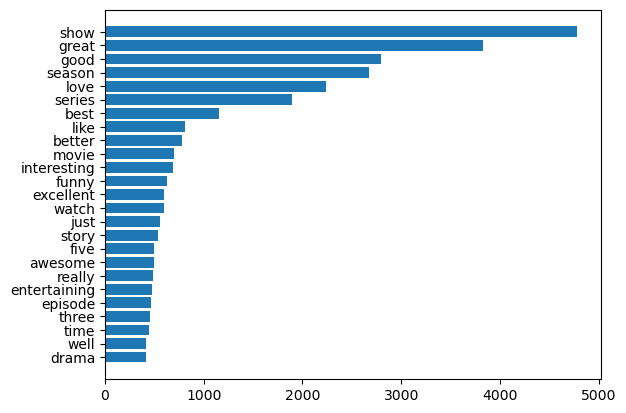

N-grams de todas las reviews

Bigramas más frecuentes


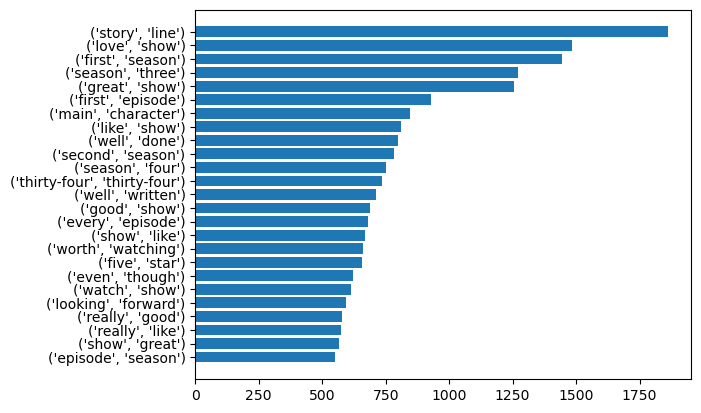

Trigramas más frecuentes


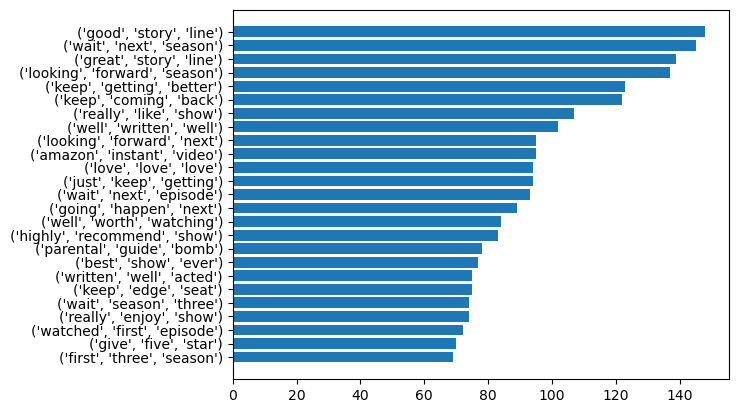

N-grams de todas los summary

Bigramas más frecuentes


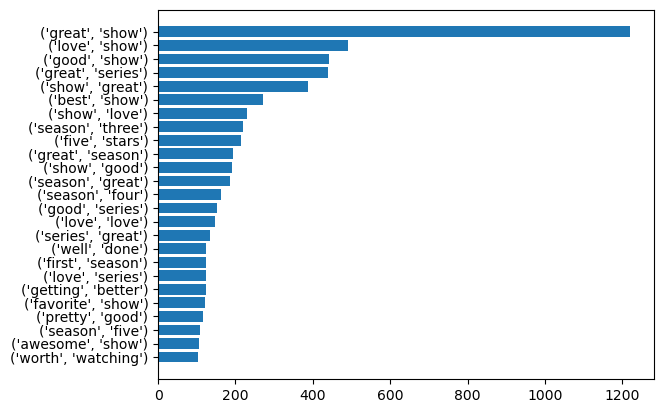

Trigramas más frecuentes


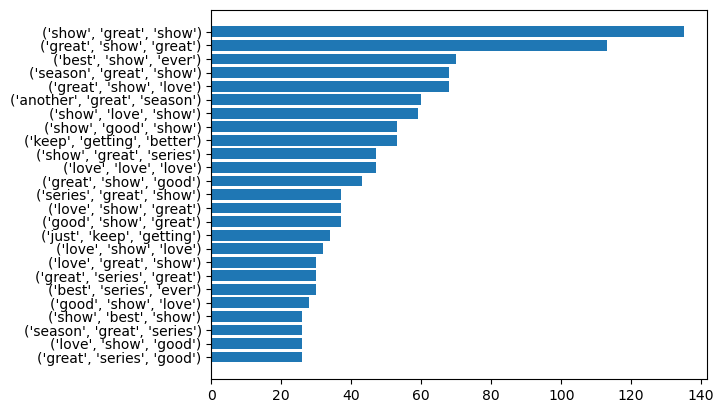

Nube de palabras para reviews


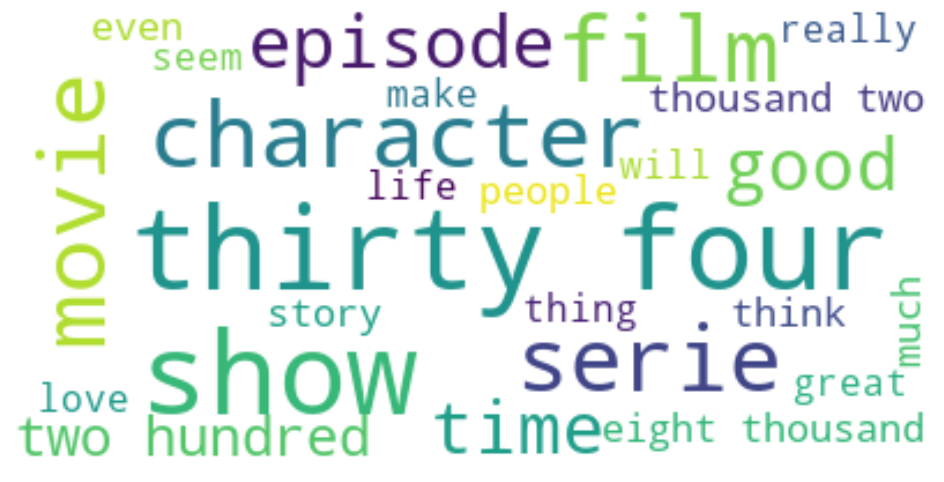

Nube de palabras para summary


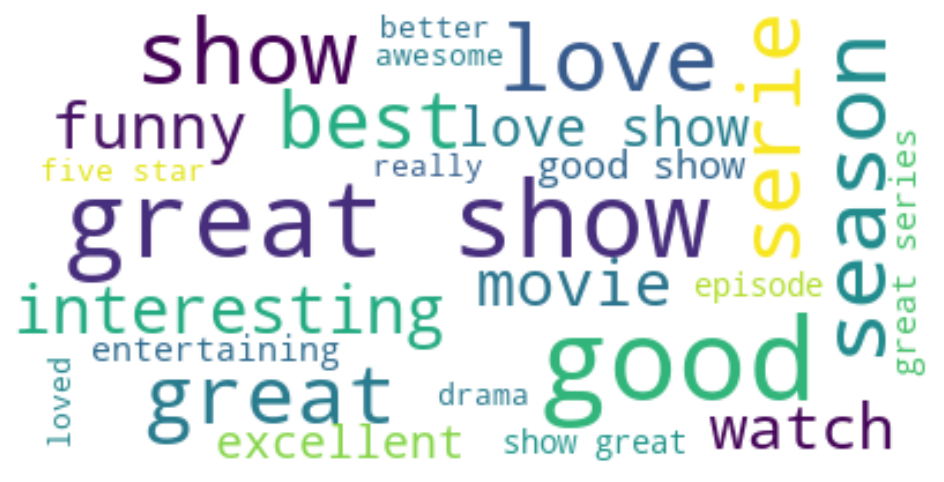

In [16]:
words_in_reviews, words_in_summary = general()

In [17]:
def por_estrellas():
    text = ['Palabras', 'Bigramas', 'Trigramas']
    for i in range(5,0,-1):
        n_gram_reviews = n_grams('reviewText', i)  
        n_gram_summary = n_grams('summary', i) 

        print(f'{text[0]} mas frecuentes para reviewText con {i} estrellas')
        crear_histo(n_gram_reviews[3])
        print(f'{text[0]} mas frecuentes para summary con {i} estrellas')
        crear_histo(n_gram_summary[3])
        
        print (f'N-grams\n')
        for j in range(1,3):
            print(f'{text[j]} más frecuentes para reviewText')
            crear_histo(n_gram_reviews[j])
            print(f'{text[j]} más frecuentes para summary')
            crear_histo(n_gram_summary[j])

        print ('Nube de palabras para reviewText')
        plot_word_cloud(n_gram_reviews[0])
        print ('Nube de palabras para summary')
        plot_word_cloud(n_gram_summary[0])

Palabras mas frecuentes para reviewText con 5 estrellas


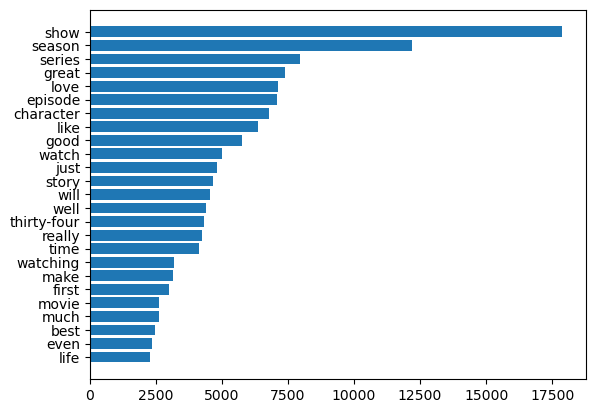

Palabras mas frecuentes para summary con 5 estrellas


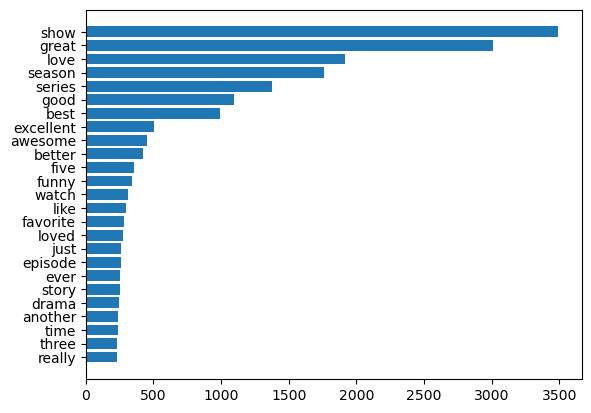

N-grams

Bigramas más frecuentes para reviewText


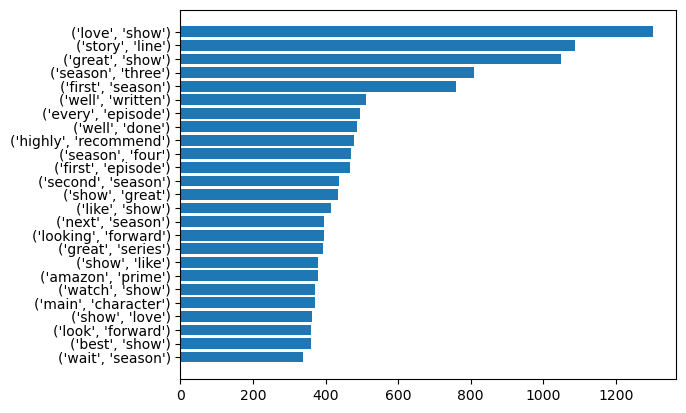

Bigramas más frecuentes para summary


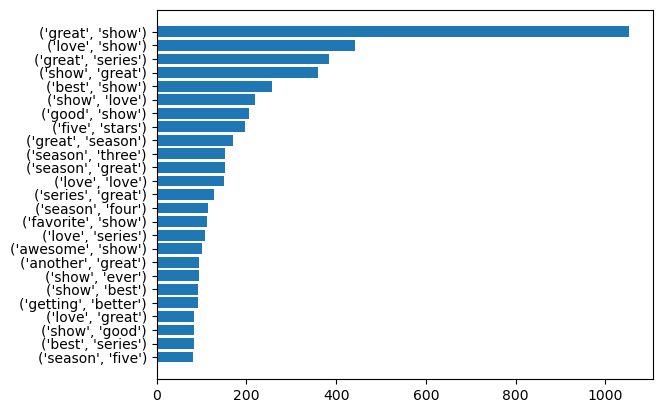

Trigramas más frecuentes para reviewText


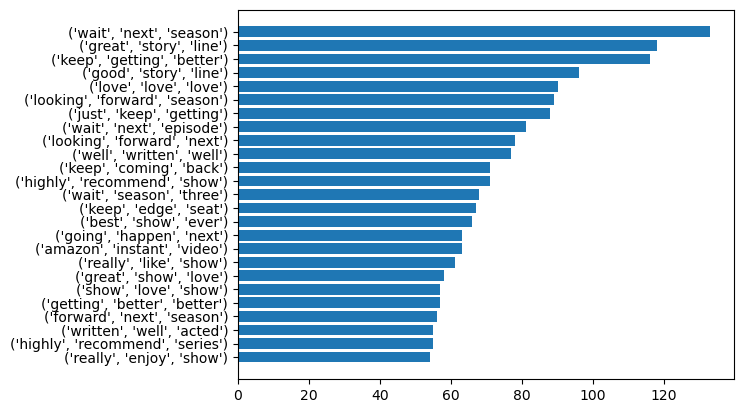

Trigramas más frecuentes para summary


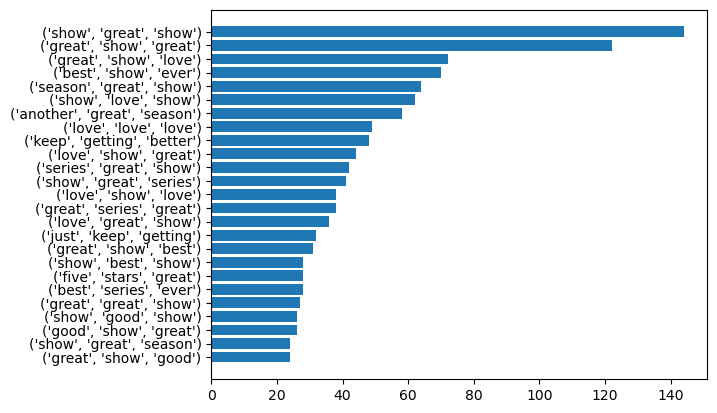

Nube de palabras para reviewText


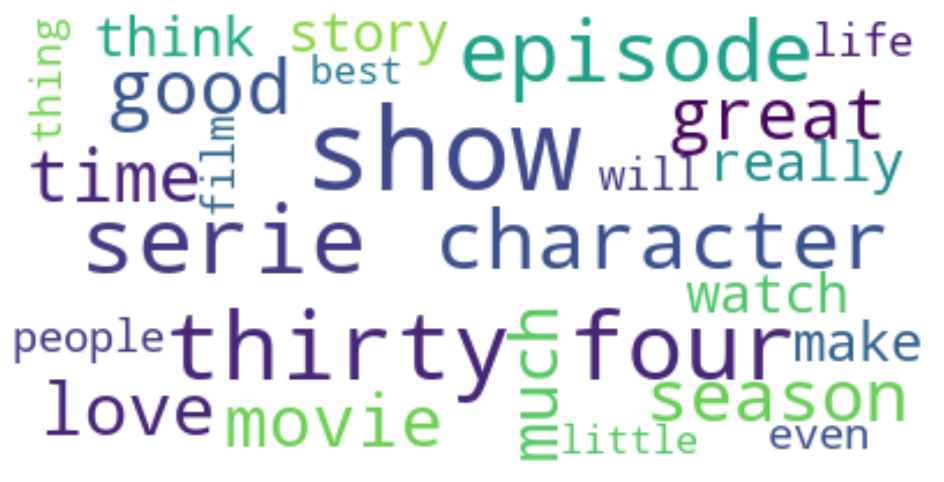

Nube de palabras para summary


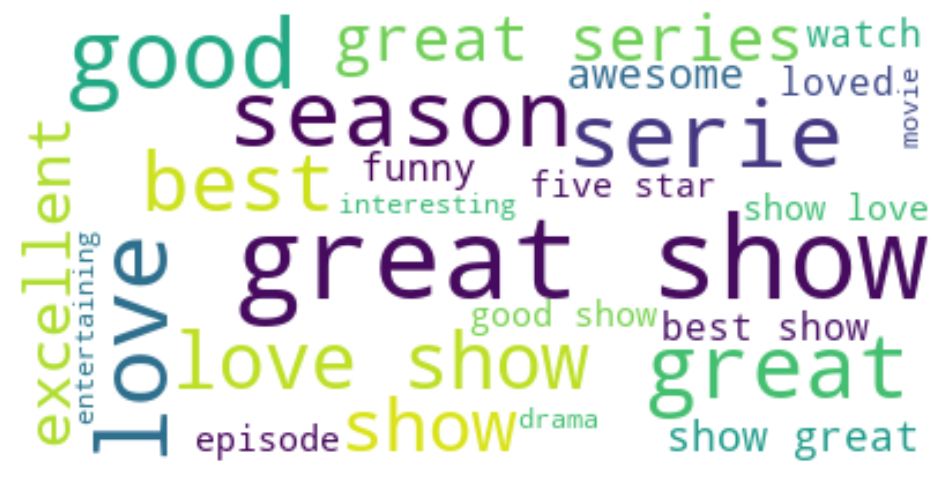

Palabras mas frecuentes para reviewText con 4 estrellas


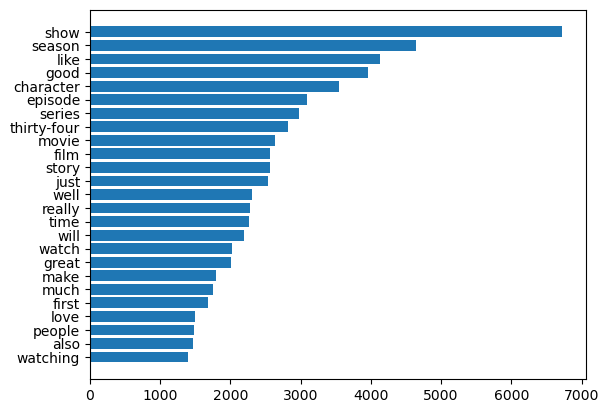

Palabras mas frecuentes para summary con 4 estrellas


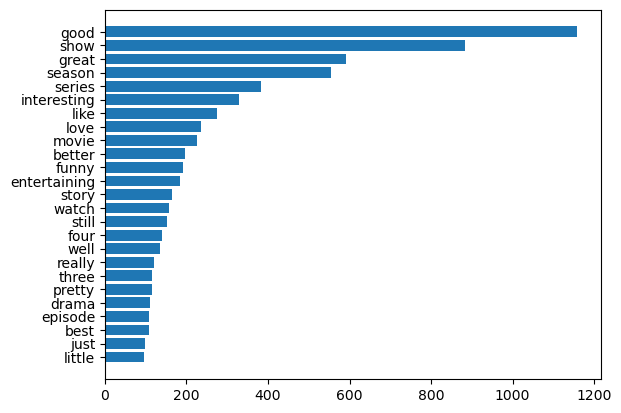

N-grams

Bigramas más frecuentes para reviewText


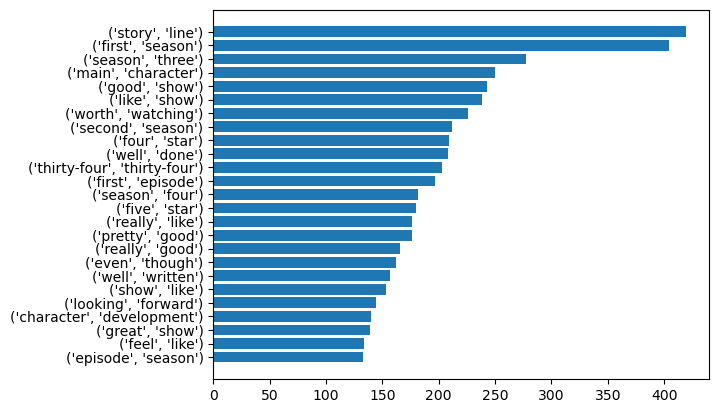

Bigramas más frecuentes para summary


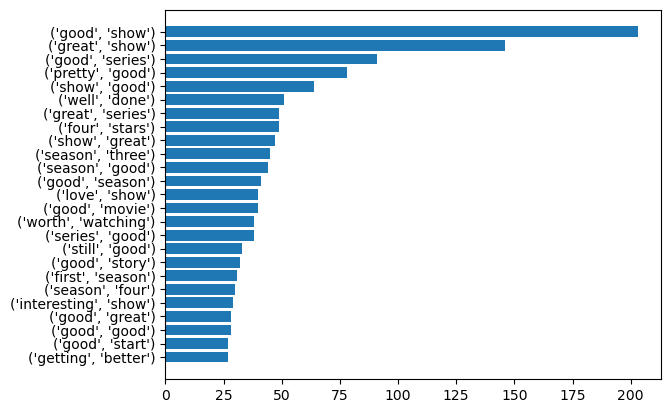

Trigramas más frecuentes para reviewText


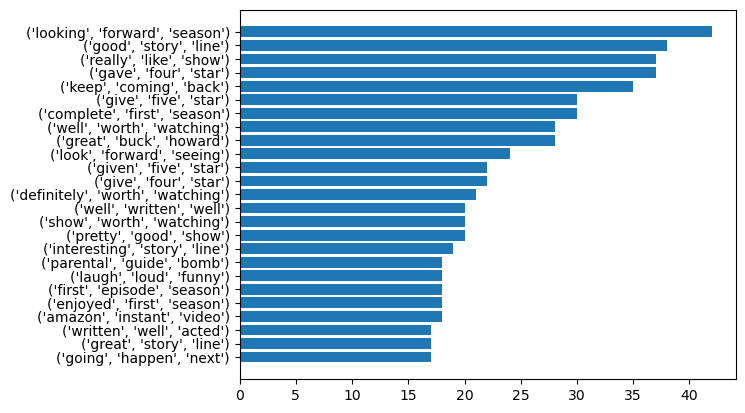

Trigramas más frecuentes para summary


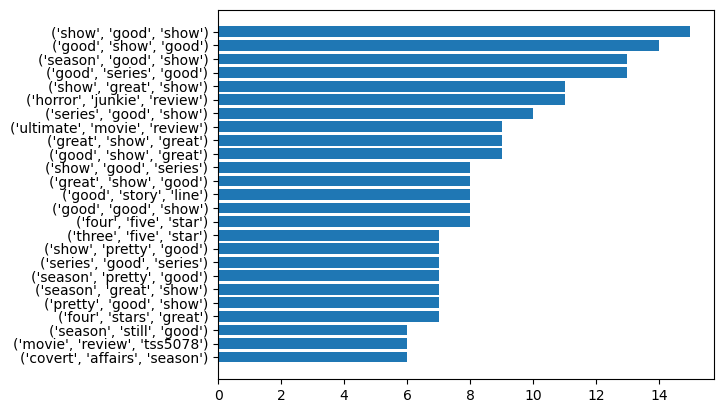

Nube de palabras para reviewText


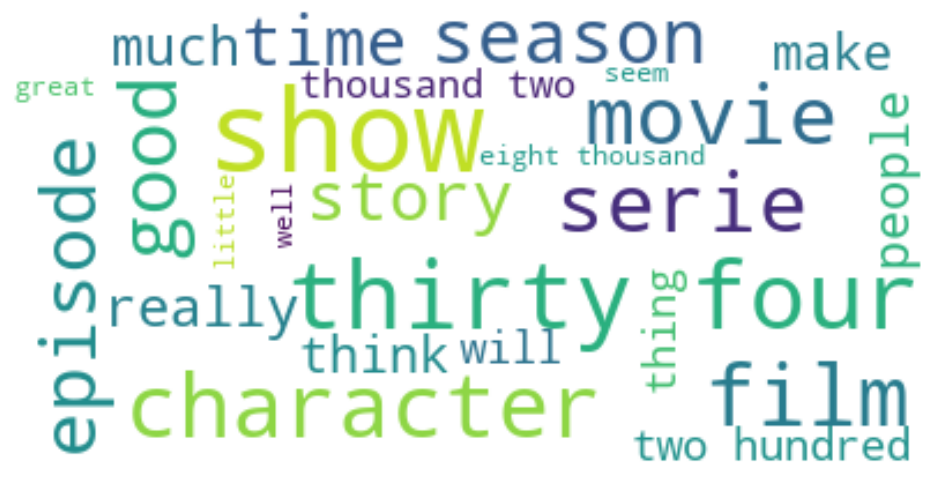

Nube de palabras para summary


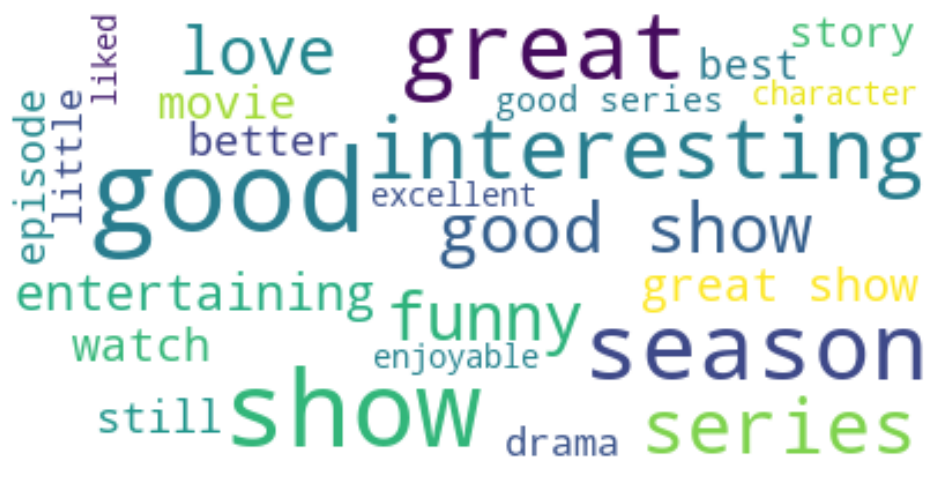

Palabras mas frecuentes para reviewText con 3 estrellas


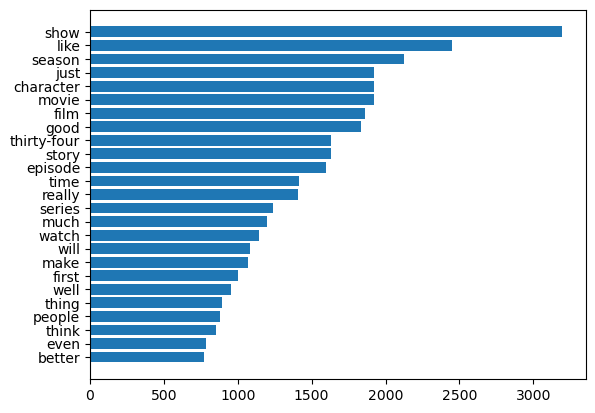

Palabras mas frecuentes para summary con 3 estrellas


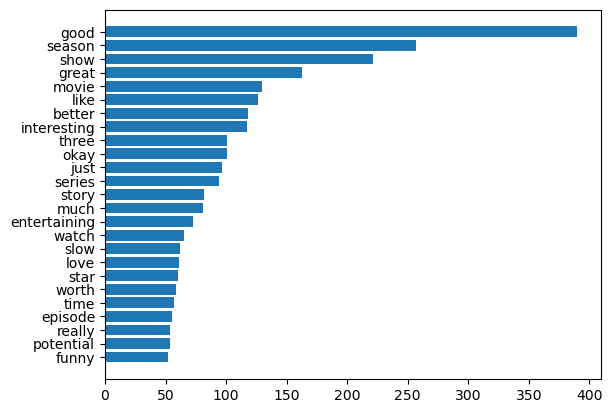

N-grams

Bigramas más frecuentes para reviewText


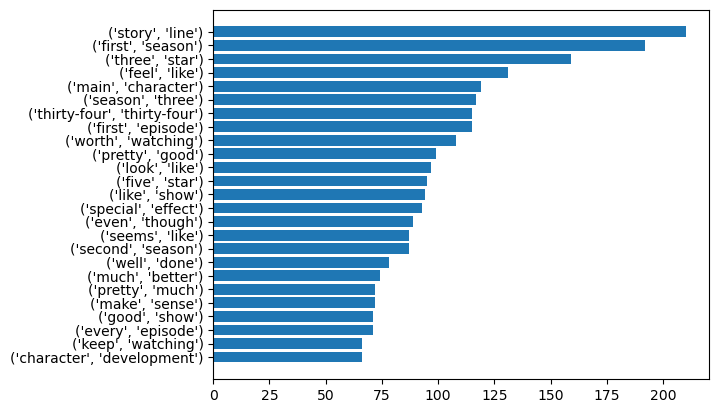

Bigramas más frecuentes para summary


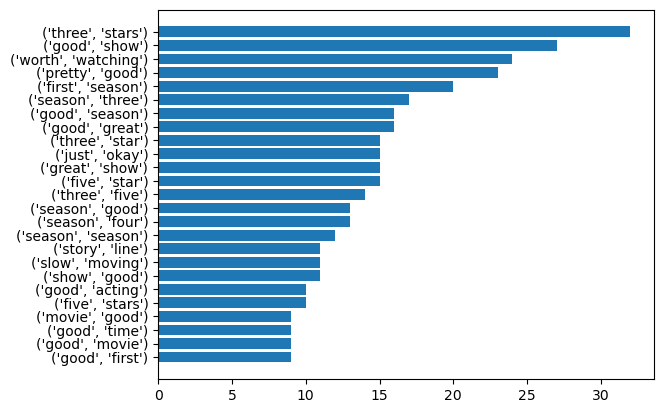

Trigramas más frecuentes para reviewText


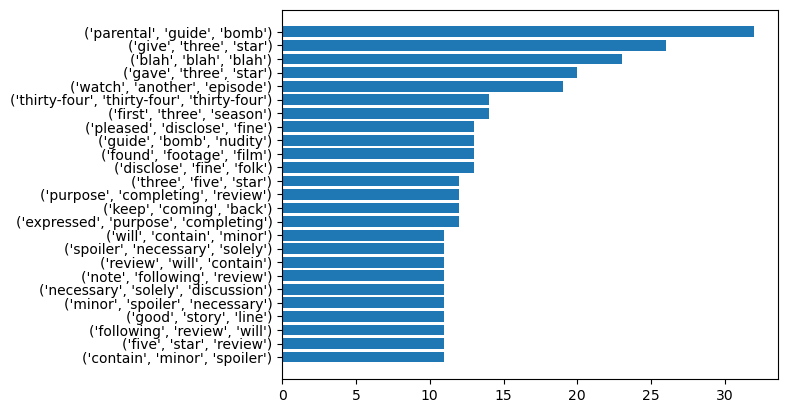

Trigramas más frecuentes para summary


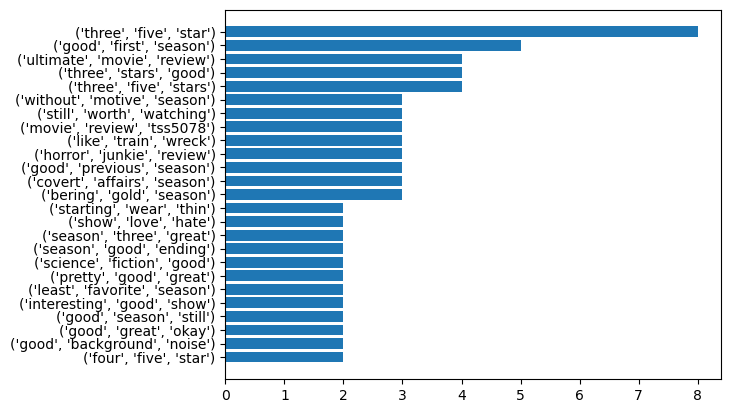

Nube de palabras para reviewText


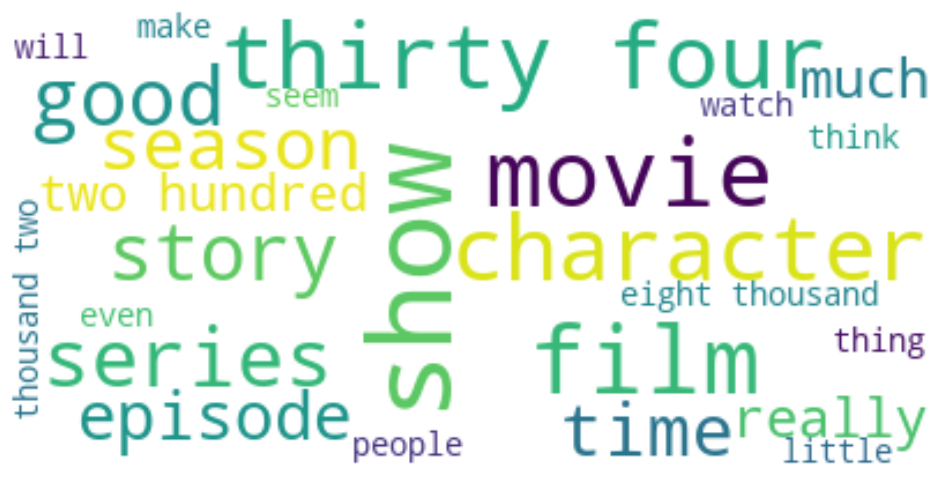

Nube de palabras para summary


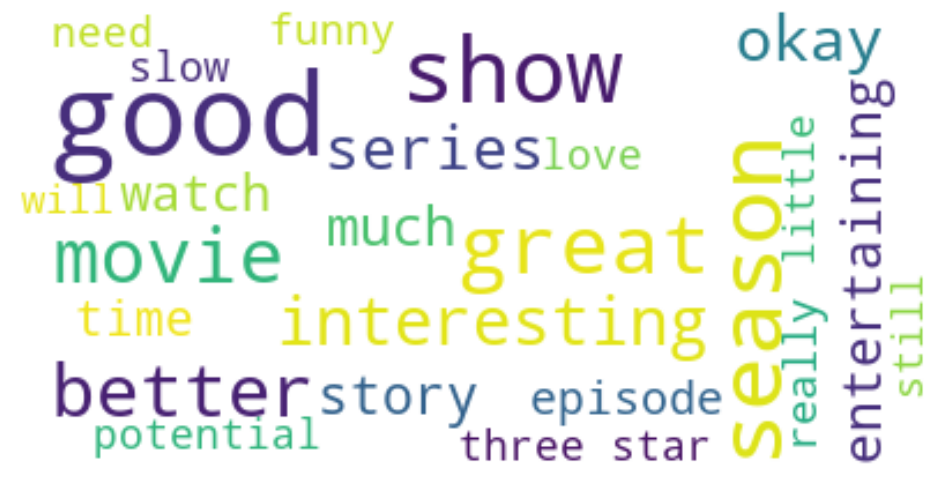

Palabras mas frecuentes para reviewText con 2 estrellas


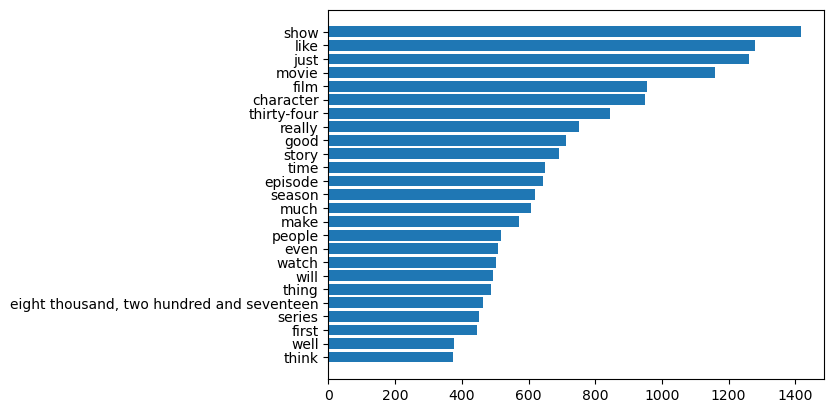

Palabras mas frecuentes para summary con 2 estrellas


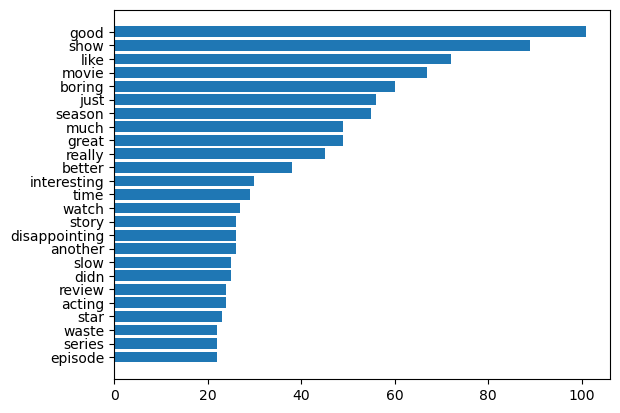

N-grams

Bigramas más frecuentes para reviewText


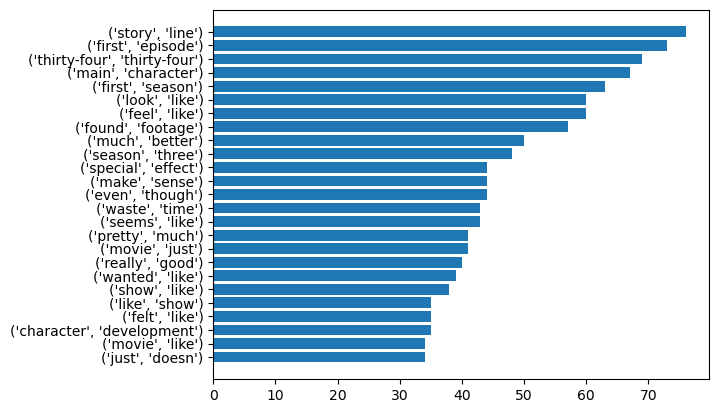

Bigramas más frecuentes para summary


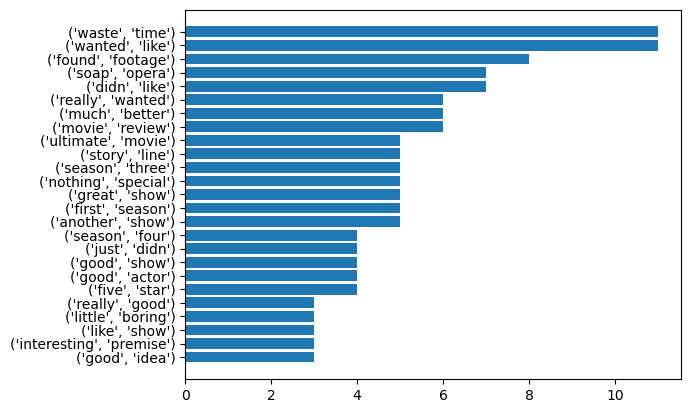

Trigramas más frecuentes para reviewText


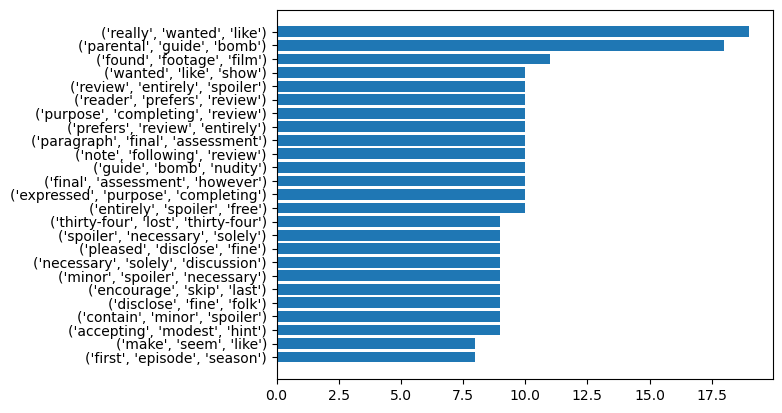

Trigramas más frecuentes para summary


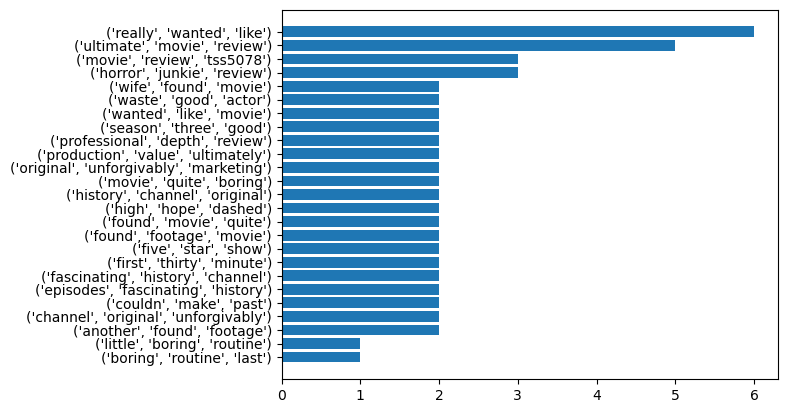

Nube de palabras para reviewText


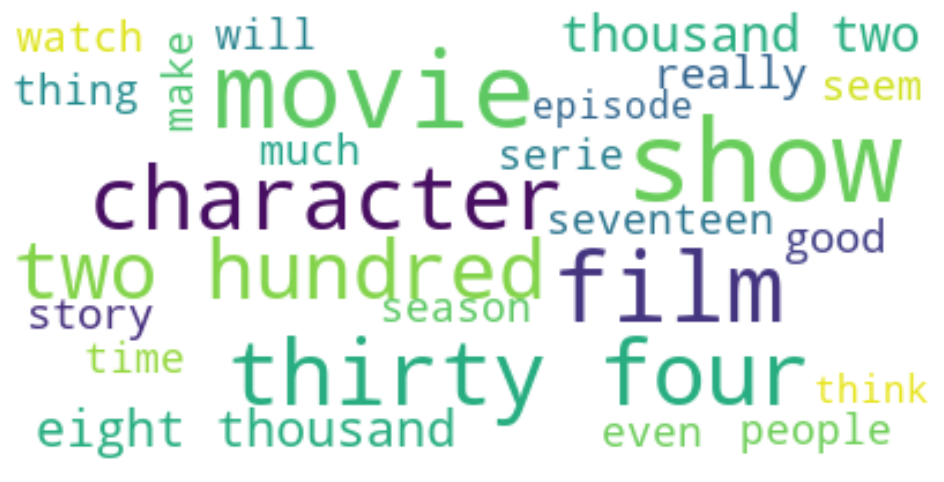

Nube de palabras para summary


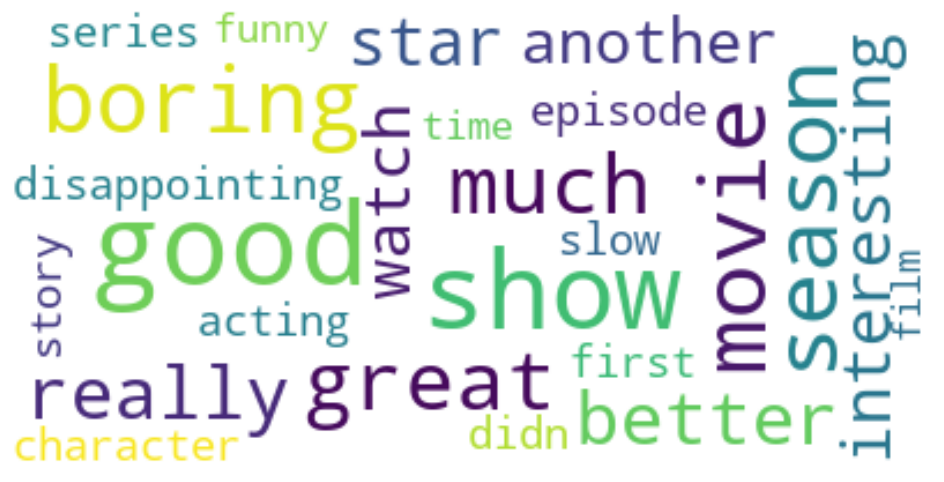

Palabras mas frecuentes para reviewText con 1 estrellas


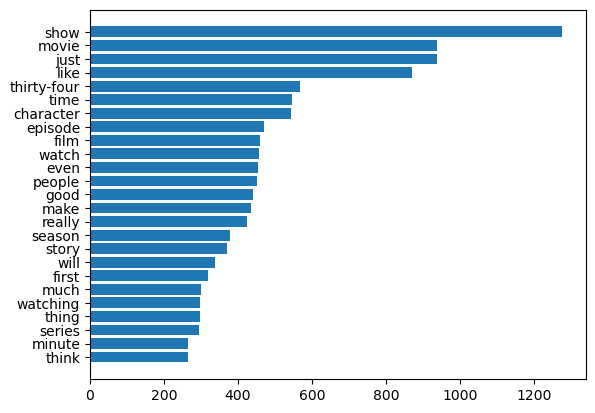

Palabras mas frecuentes para summary con 1 estrellas


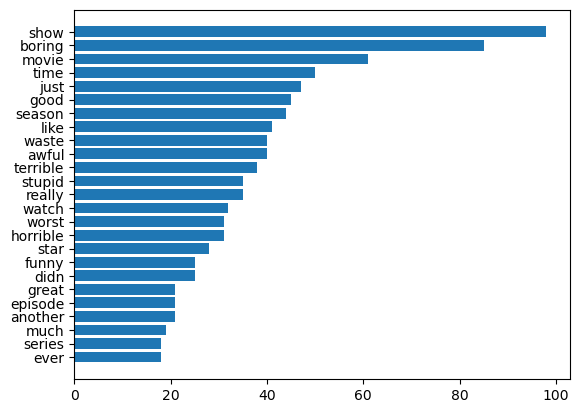

N-grams

Bigramas más frecuentes para reviewText


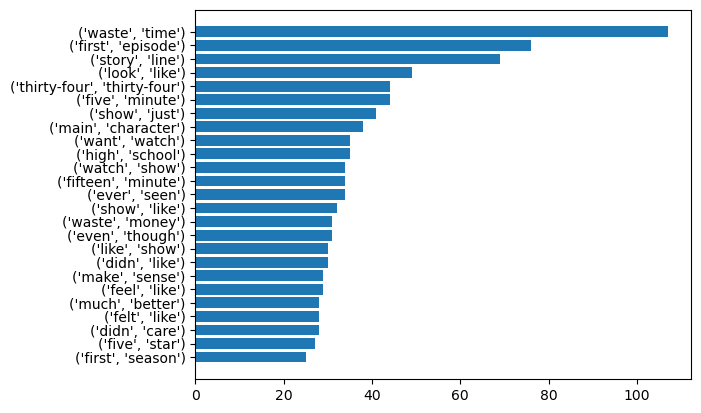

Bigramas más frecuentes para summary


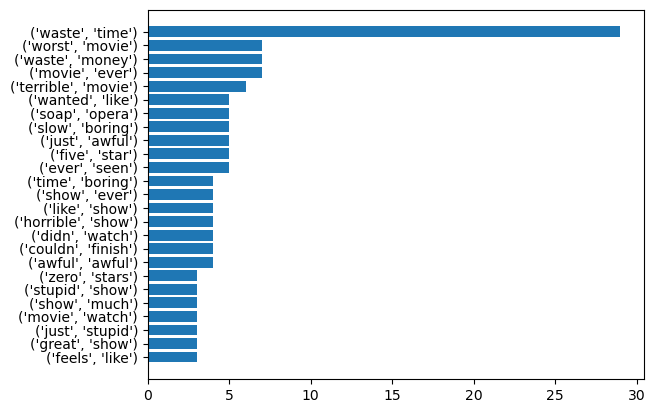

Trigramas más frecuentes para reviewText


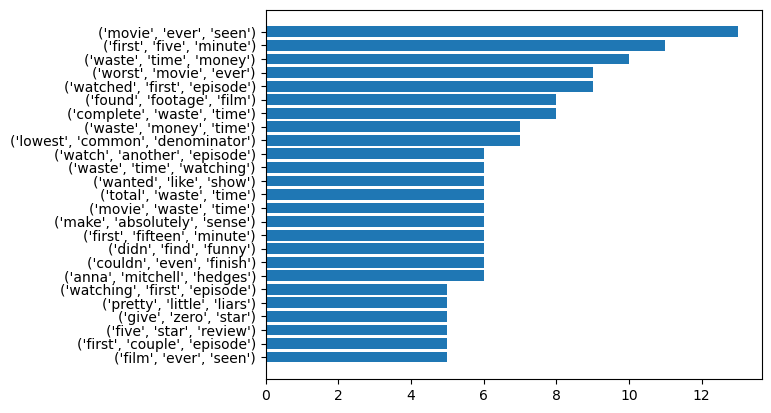

Trigramas más frecuentes para summary


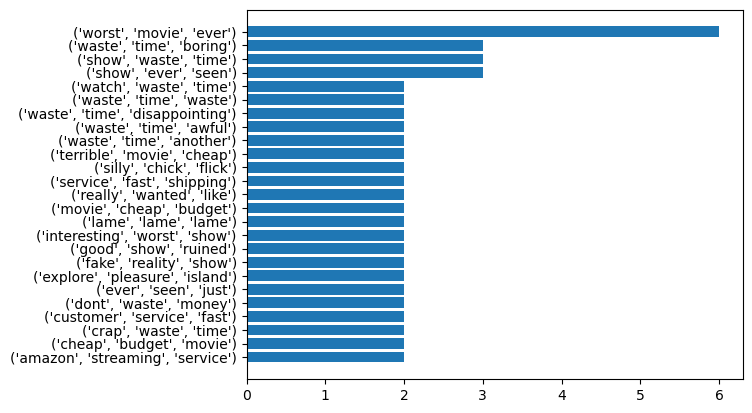

Nube de palabras para reviewText


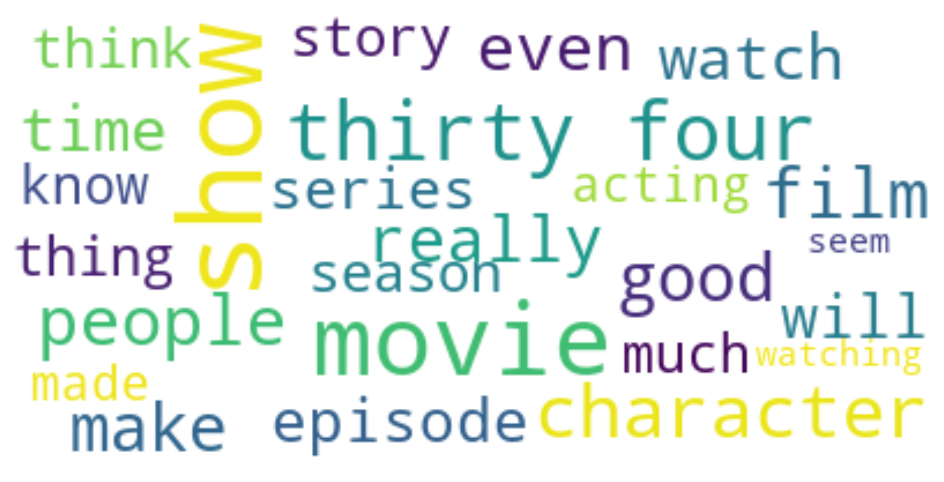

Nube de palabras para summary


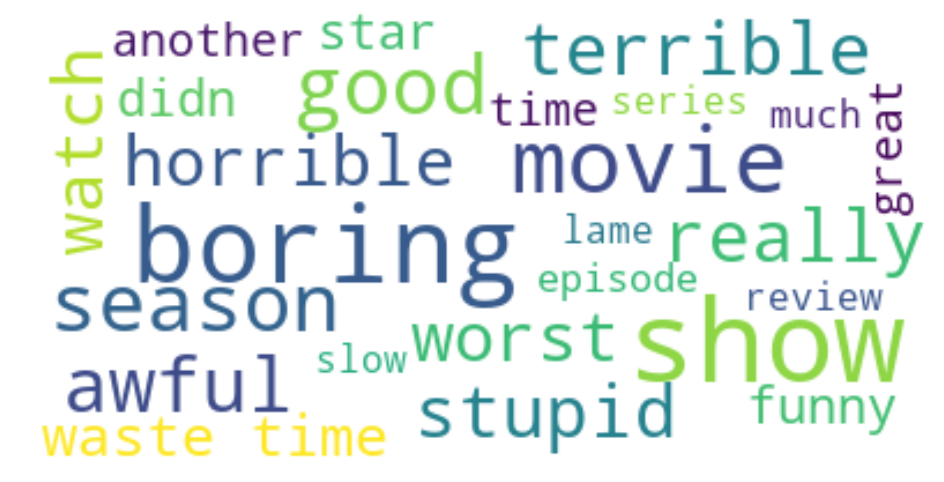

In [18]:
por_estrellas() 

Se sigue apreciando que en summary tienen más importacia los calificativos que en reviewText. 

### Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec y con FastText

Lo haremos con las reviews cinco estrellas.

In [19]:
sentences_reviewText =\
    ' '.join([WordNetLemmatizer().lemmatize(word) for word in words_in_reviews])
sentences_summary =\
    ' '.join([WordNetLemmatizer().lemmatize(word) for word in words_in_summary])

Guardamos el corpus en un .txt para volver a instanciarlo para evitar problemas del método seek() con LineSentence:

In [20]:
with open('corpus_reviewText.txt', 'w') as text_file:
    text_file.write(sentences_reviewText)
corpus_reviews = LineSentence('corpus_reviewText.txt')

with open('corpus_summary.txt', 'w') as text_file:
    text_file.write(sentences_summary)
corpus_summary = LineSentence('corpus_summary.txt')

In [21]:
def crear_cluster(model, keys):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for sim in model.wv.most_similar(word, topn=10):
            words.append(sim)
            embeddings.append(model.wv[sim[0]])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return embedding_clusters, word_clusters

def dim_2D(embedding_clusters):
    
    tsne_model_2d = TSNE(perplexity=15,
                         n_components=2,
                         init='pca',
                         n_iter=3500,
                         random_state=32)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape

    embeddings_2d = np.array(
        tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_2d

def print_sim_words(keys, word_clusters):
    for i, key in enumerate(keys):
        query = "Most similar to {}".format(key) 
        print(query)
        print("-"*len(query))
        for sim in word_clusters[i]:
            print(sim[0], "......", round(sim[1]*100, 2),"%")
        print("\n")
        
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word[0], alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    plt.show()    

#### Word2Vec 

In [22]:
cbow_params = {
    'sg': 0,
    'vector_size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

keys = ['show','good','great','waste','boring','terrible']

w2v_cbow = Word2Vec(**cbow_params)

reviewText

In [23]:
w2v_cbow.build_vocab(corpus_reviews)
w2v_cbow.train(corpus_reviews, total_examples = w2v_cbow.corpus_count, epochs=10)
w2v_cbow.save('w2v_sg_d300_mc5_w5.pkl')
print('Vocabulario compuesto por {} palabras'.format(len(w2v_cbow.wv)))

Vocabulario compuesto por 16137 palabras


In [24]:
embedding_clusters, word_clusters = crear_cluster(w2v_cbow, keys)
embeddings_2d = dim_2D(embedding_clusters)
print_sim_words(keys, word_clusters)   

Most similar to show
--------------------
series ...... 77.02 %
program ...... 72.16 %
justified ...... 58.08 %
season ...... 56.5 %
episode ...... 54.05 %
watch ...... 54.0 %
pilot ...... 52.93 %
addictive ...... 52.58 %
sitcom ...... 51.37 %
cancel ...... 51.17 %


Most similar to good
--------------------
great ...... 74.47 %
decent ...... 67.91 %
excellent ...... 62.34 %
solid ...... 57.53 %
interesting ...... 55.33 %
fantastic ...... 53.83 %
awesome ...... 53.71 %
enjoyable ...... 53.47 %
engaging ...... 53.01 %
notch ...... 52.28 %


Most similar to great
---------------------
excellent ...... 77.08 %
wonderful ...... 74.77 %
good ...... 74.47 %
fantastic ...... 71.65 %
terrific ...... 69.67 %
awesome ...... 67.29 %
amazing ...... 65.37 %
superb ...... 64.59 %
outstanding ...... 63.54 %
notch ...... 62.38 %


Most similar to waste
---------------------
wasted ...... 79.87 %
wasting ...... 75.92 %
spend ...... 70.45 %
spent ...... 63.68 %
invest ...... 54.86 %
slot ...... 54.78 %


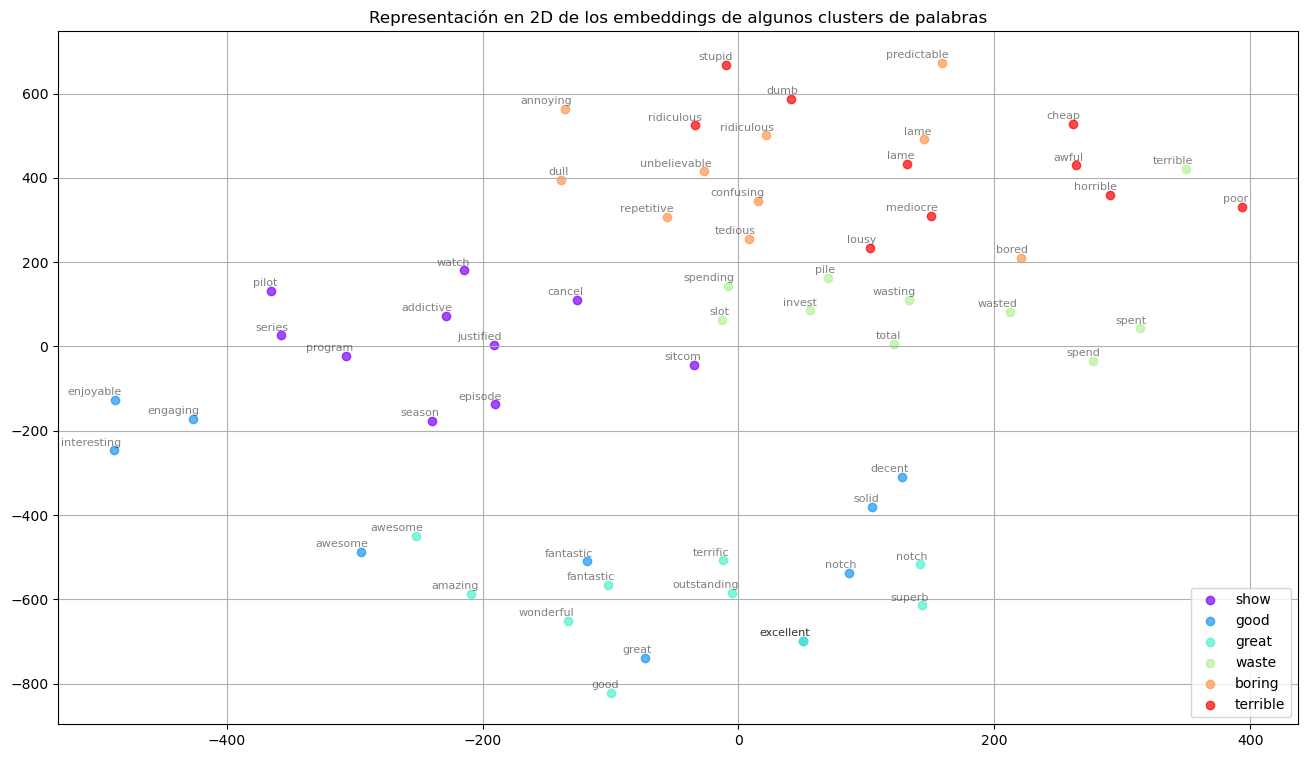

In [25]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

In [26]:
w2v_cbow.build_vocab(corpus_summary)
w2v_cbow.train(corpus_summary, total_examples = w2v_cbow.corpus_count, epochs=10)
w2v_cbow.save('w2v_sg_d300_mc5_w5.pkl')
print('Vocabulario compuesto por {} palabras'.format(len(w2v_cbow.wv)))

Vocabulario compuesto por 2257 palabras


In [27]:
embedding_clusters, word_clusters = crear_cluster(w2v_cbow, keys)
embeddings_2d = dim_2D(embedding_clusters)
print_sim_words(keys, word_clusters)  

Most similar to show
--------------------
picking ...... 32.98 %
moral ...... 32.75 %
hungry ...... 31.56 %
cheesy ...... 30.41 %
producer ...... 30.13 %
great ...... 30.04 %
justified ...... 28.98 %
thinking ...... 27.87 %
recommended ...... 27.48 %
pain ...... 27.28 %


Most similar to good
--------------------
hungry ...... 49.18 %
visually ...... 38.18 %
great ...... 36.82 %
alpha ...... 34.53 %
masterpiece ...... 33.69 %
poorly ...... 33.24 %
fest ...... 32.59 %
actor ...... 30.94 %
tragic ...... 29.7 %
pride ...... 29.54 %


Most similar to great
---------------------
purchased ...... 51.48 %
park ...... 45.58 %
experience ...... 39.36 %
good ...... 36.82 %
rate ...... 36.6 %
excellent ...... 35.89 %
tragic ...... 35.83 %
reality ...... 34.88 %
breath ...... 34.81 %
chance ...... 34.61 %


Most similar to waste
---------------------
focus ...... 48.08 %
despite ...... 45.71 %
house ...... 45.56 %
watchable ...... 44.54 %
entertains ...... 42.94 %
consistently ...... 42.8 %
game .

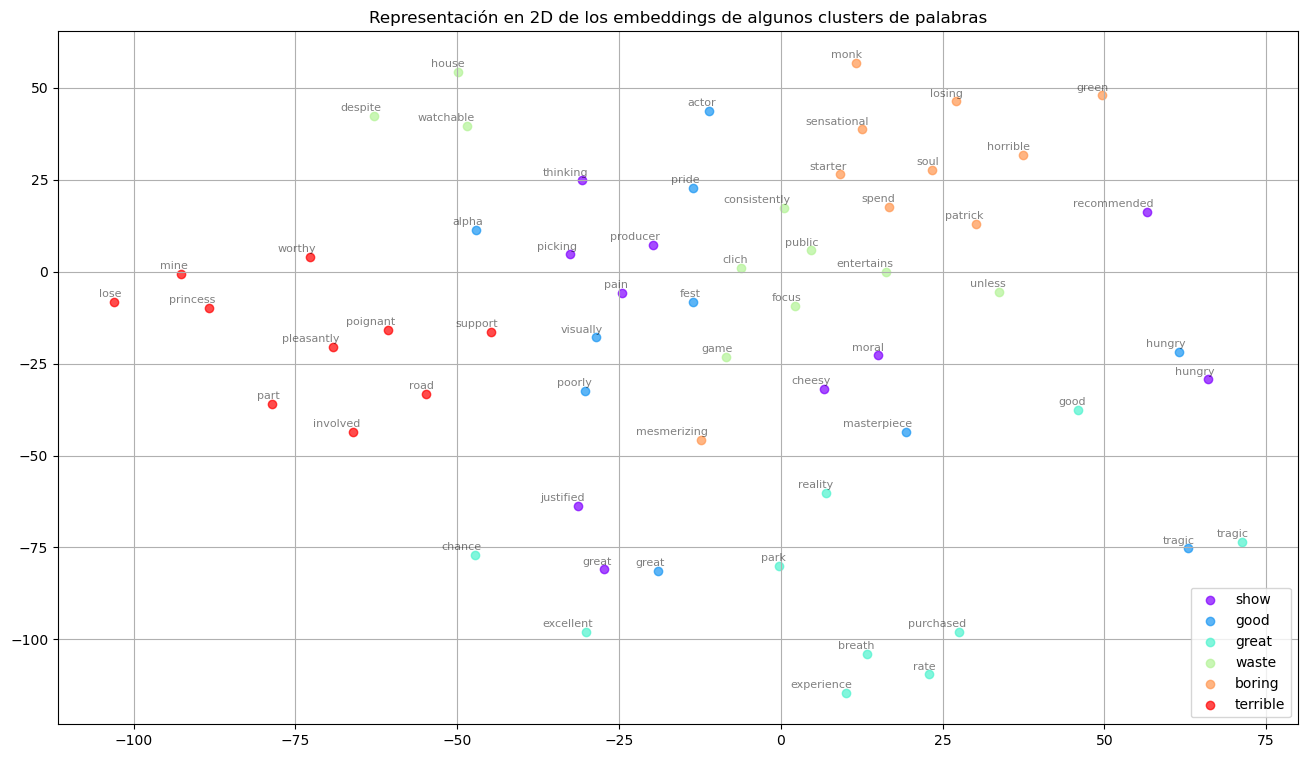

In [28]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

#### FastText

In [29]:
cbow_params = {
    'sg': 0,
    'vector_size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4,
    'min_n': 3,
    'max_n': 6
}

In [30]:
ft_cbow = FastText(**cbow_params)
ft_cbow.build_vocab(corpus_reviews)
ft_cbow.train(corpus_reviews, total_examples=ft_cbow.corpus_count, epochs=10)
ft_cbow.save('ft_cbow_d300_mc5_w5.pkl')
print('Vocabulario compuesto por {} palabras'.format(len(ft_cbow.wv)))

Vocabulario compuesto por 16137 palabras


In [31]:
embedding_clusters, word_clusters = crear_cluster(ft_cbow, keys)
embeddings_2d = dim_2D(embedding_clusters)
print_sim_words(keys, word_clusters) 

Most similar to show
--------------------
copshow ...... 84.41 %
roadshow ...... 77.26 %
showy ...... 76.79 %
program ...... 74.63 %
series ...... 73.72 %
programme ...... 71.69 %
programmed ...... 67.58 %
programing ...... 66.97 %
programming ...... 66.49 %
programmer ...... 66.0 %


Most similar to good
--------------------
goode ...... 89.44 %
goody ...... 83.01 %
goof ...... 78.82 %
goodbye ...... 77.57 %
goodwin ...... 74.86 %
great ...... 73.36 %
goofy ...... 72.76 %
goodwill ...... 69.38 %
agreat ...... 68.99 %
god ...... 67.03 %


Most similar to great
---------------------
agreat ...... 91.34 %
greasy ...... 76.99 %
excellent ...... 75.98 %
greatly ...... 75.09 %
wonderful ...... 74.96 %
fantastic ...... 74.95 %
good ...... 73.36 %
greatness ...... 70.98 %
excelled ...... 70.48 %
greater ...... 70.34 %


Most similar to waste
---------------------
wasted ...... 83.35 %
wasa ...... 78.28 %
waster ...... 78.15 %
washy ...... 73.46 %
taste ...... 73.11 %
wasteland ...... 70.97 %


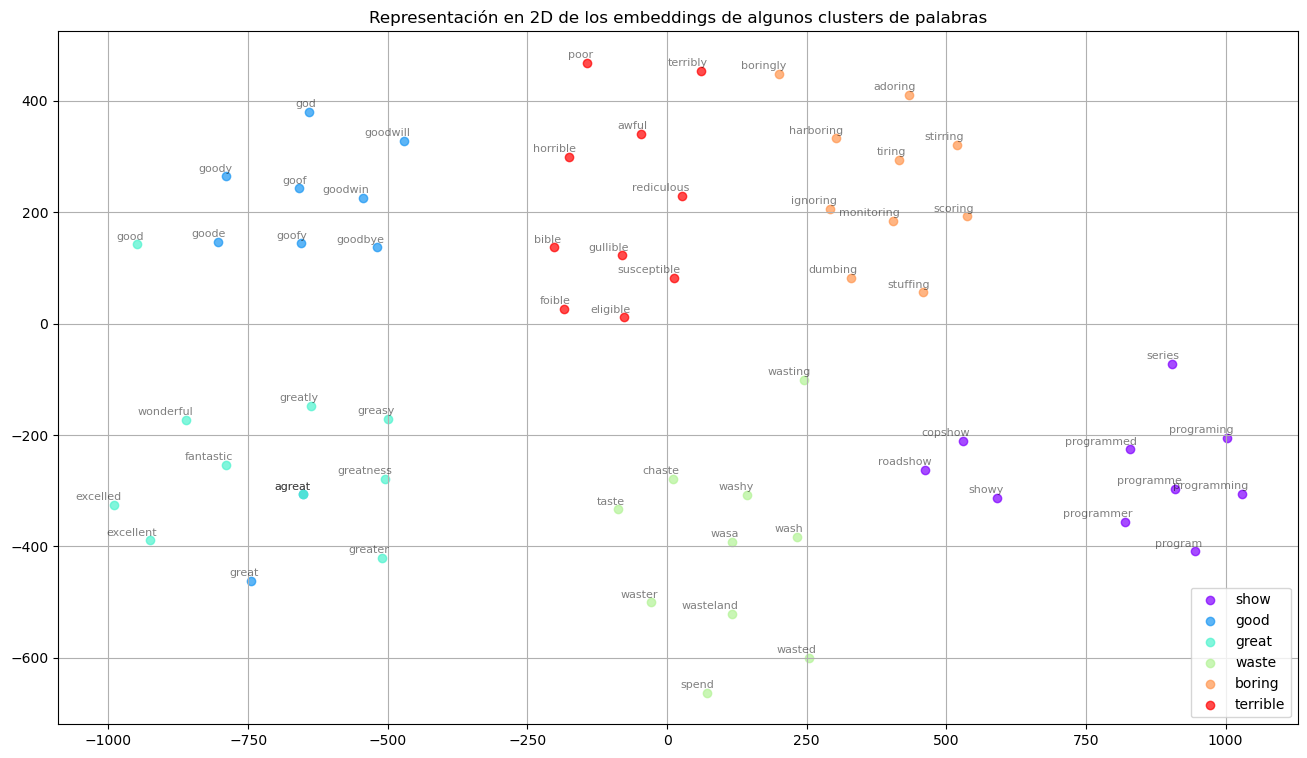

In [32]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

In [33]:
ft_cbow = FastText(**cbow_params)
ft_cbow.build_vocab(corpus_summary)
ft_cbow.train(corpus_summary, total_examples=ft_cbow.corpus_count, epochs=10)
ft_cbow.save('ft_cbow_d300_mc5_w5.pkl')
print('Vocabulario compuesto por {} palabras'.format(len(ft_cbow.wv)))

Vocabulario compuesto por 2257 palabras


In [34]:
embedding_clusters, word_clusters = crear_cluster(ft_cbow, keys)
embeddings_2d = dim_2D(embedding_clusters)
print_sim_words(keys, word_clusters)  

Most similar to show
--------------------
great ...... 98.49 %
series ...... 96.96 %
grimm ...... 96.43 %
awesome ...... 96.4 %
grim ...... 96.36 %
justified ...... 96.25 %
seat ...... 95.91 %
suit ...... 95.65 %
continues ...... 94.66 %
best ...... 94.25 %


Most similar to good
--------------------
cast ...... 98.81 %
addicting ...... 98.65 %
character ...... 98.31 %
showing ...... 98.11 %
excellent ...... 98.09 %
enjoyed ...... 98.01 %
continuing ...... 97.98 %
amazing ...... 97.95 %
enjoying ...... 97.94 %
enjoys ...... 97.87 %


Most similar to great
---------------------
show ...... 98.49 %
series ...... 97.73 %
grim ...... 96.98 %
awesome ...... 96.77 %
suit ...... 96.55 %
grimm ...... 96.53 %
seat ...... 96.03 %
justified ...... 95.49 %
continues ...... 95.16 %
grit ...... 95.1 %


Most similar to waste
---------------------
sake ...... 99.81 %
bore ...... 99.78 %
matein ...... 99.77 %
football ...... 99.76 %
else ...... 99.73 %
within ...... 99.72 %
report ...... 99.71 %
troll

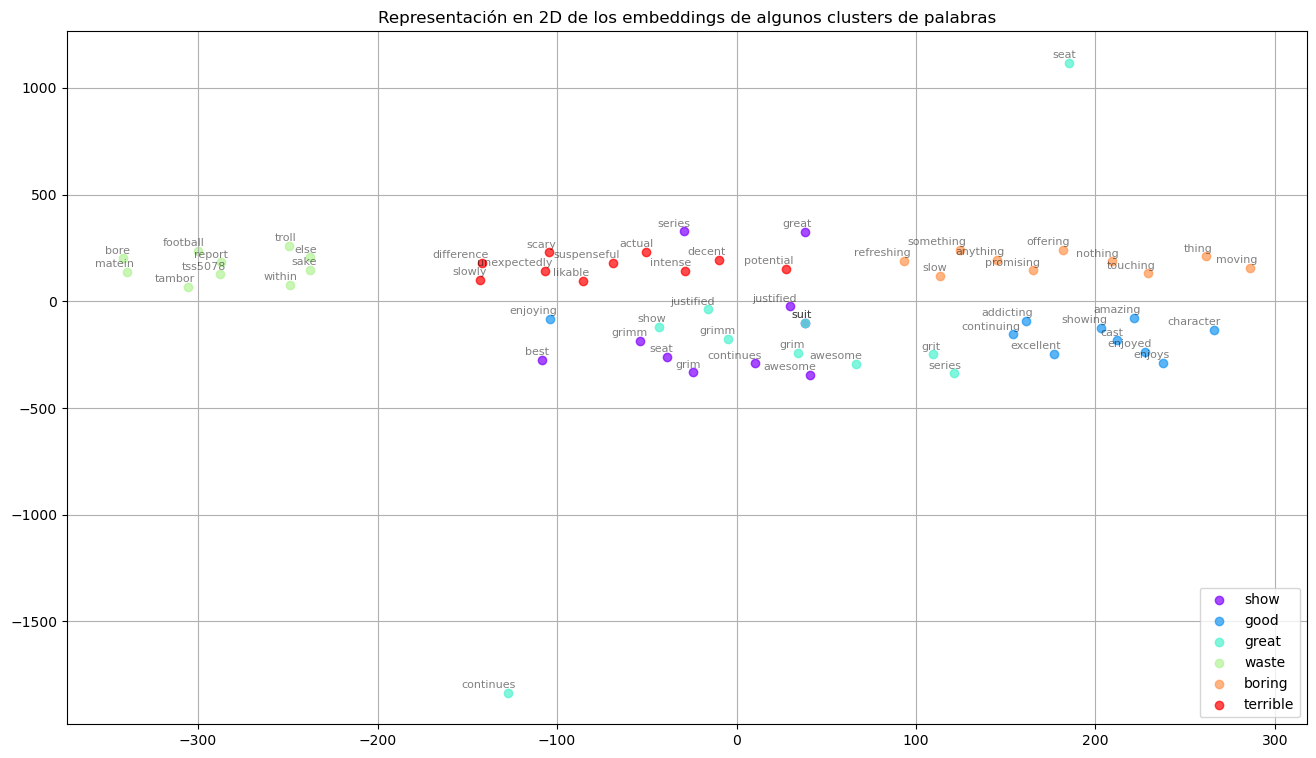

In [35]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)